# First data explorations & messy transformations

In [1]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()  # this makes my plots pretty
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation as cv

from skll import metrics
from sklearn.metrics import make_scorer

import data_utils

In [2]:
train = pd.read_csv('../../data/train.csv').drop(['Id'], axis=1)
test = pd.read_csv('../../data/test.csv')

In [3]:
train = pd.get_dummies(train, columns=['Product_Info_2'])
test = pd.get_dummies(test, columns=['Product_Info_2'])

In [4]:
# fill NaN values for Familiy_Hist_2-5 with means
for i in range(2, 6):
    col = 'Family_Hist_%i' % i
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())
# and everything else with 0
train = train.fillna(0)
test = test.fillna(0)

## Train a basic Random Forest

In [5]:
kappa_scorer = make_scorer(metrics.kappa, weights='quadratic')

In [6]:
X_train = train.drop(['Response'], axis=1).values
y_train = train.Response.values
rfr_params = {'n_estimators': 300, 'random_state': 42, 'n_jobs': -1}
model = RandomForestClassifier(**rfr_params)
folds = cv.KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=42)
scores = cv.cross_val_score(model, X_train, y_train, cv=folds, scoring=kappa_scorer, n_jobs=-1)
print(scores)
print(scores.mean(), scores.std())

[ 0.49593096  0.50901067  0.5108705   0.49834324  0.49726198]
(0.50228346962076531, 0.0063259403571169865)


### Predict testdata

In [7]:
X_test = test.drop(['Id'], axis=1).values
rfr_params = {'n_estimators': 300, 'random_state': 42, 'n_jobs': -1}
model = RandomForestClassifier(**rfr_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
data_utils.write_submission(y_pred, test)

### Scores

**CV**
[ 0.49593096  0.50901067  0.5108705   0.49834324  0.49726198] (0.50228346962076531, 0.0063259403571169865)

**LB**
0.51081

## Some plots to get a feel how well the basic random forest does
### Train on a 80% training set of our training examples

In [9]:
X = train.drop(['Response'], axis=1).values
y = train.Response.values
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rfr_params = {'n_estimators': 300, 'random_state': 42, 'n_jobs': -1}
model = RandomForestClassifier(**rfr_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Plot histogram of classes in predictions and truths

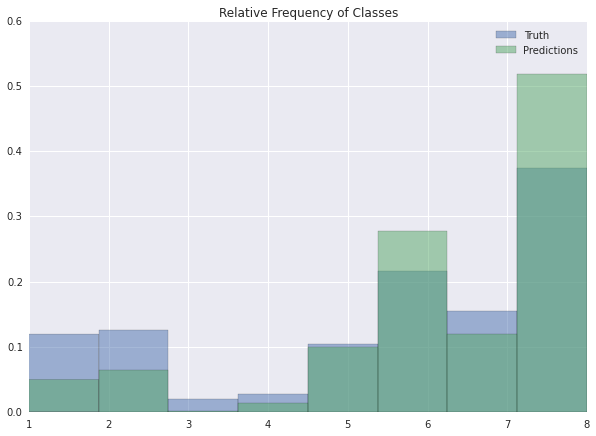

In [10]:
plt.figure(figsize=(10,7))
plt.title('Relative Frequency of Classes')
plt.hist(y_test, bins=8, normed=True, alpha=0.5, label='Truth')
plt.hist(y_pred, bins=8, normed=True, alpha=0.5, label='Predictions')
plt.legend()

So right now the model tends to predict 6 and 7 way too often and 1 and 2 way too rarely. Which also can be seen in the next plot. When the model makes a mistake it rather picks classes that are too high.

(array([ 0.00117273,  0.00306715,  0.00820914,  0.00992314,  0.00983293,
         0.02038754,  0.0635081 ,  0.59818497,  0.10897413,  0.06928156,
         0.03418973,  0.04465413,  0.03806878,  0.03635478,  0.02561975]),
 array([-7.        , -6.06666667, -5.13333333, -4.2       , -3.26666667,
        -2.33333333, -1.4       , -0.46666667,  0.46666667,  1.4       ,
         2.33333333,  3.26666667,  4.2       ,  5.13333333,  6.06666667,  7.        ]),
 <a list of 15 Patch objects>)

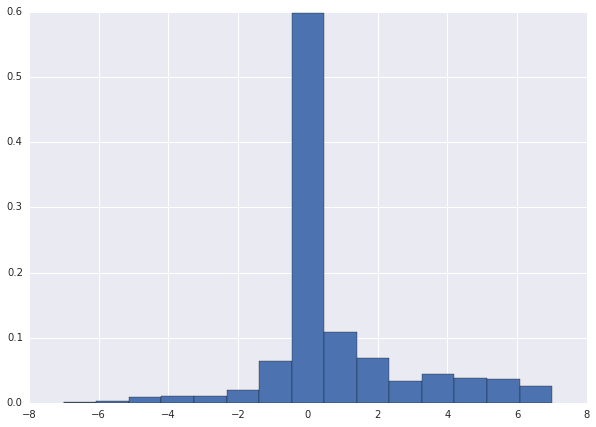

In [11]:
plt.figure(figsize=(10,7))
start = 0
end = 500
plt.hist(y_pred-y_test, bins=15, normed=True)

### Feature importance (RandomForest)
List the 50 most important features (acording to RF)

In [12]:
imp = pd.Series(model.feature_importances_, name='Importance')
names = pd.Series(train.drop(['Response'], axis=1).columns, name='Feature')
pd.concat([names, imp], axis=1).sort_values('Importance', ascending=False)[:50]

,Feature,Importance
9,BMI,0.091998
8,Wt,0.065539
6,Ins_Age,0.040944
2,Product_Info_4,0.039276
10,Employment_Info_1,0.036513
7,Ht,0.031882
37,Medical_History_2,0.030667
34,Family_Hist_4,0.030059
36,Medical_History_1,0.029745
15,Employment_Info_6,0.028929


## histograms and scatterplots of features
(deactivated)